In [1]:
# imports all helper classes/functions from utils.py, including other dependancies
from utils import *

In [2]:
# # for covid antigens, well 1

# filenames = ['BCdata_B48C13_spike_1ag_lastsweep.txt', 
#              'BCdata_B48C13_spike_10ag_lastsweep.txt', 
#              'BCdata_B48C13_spike_100ag_lastsweep.txt', 
#              'BCdata_B48C13_spike_1fg_lastsweep.txt', 
#              'BCdata_B48C13_spike_10fg_lastsweep.txt', 
#              'BCdata_B48C13_spike_100fg_lastsweep.txt', 
#              'BCdata_B48C13_spike_1pg_lastsweep.txt', 
#              'BCdata_B48C13_spike_10pg_lastsweep.txt', 
#              'BCdata_B48C13_spike_100pg_lastsweep.txt', 
#              'BCdata_B48C13_spike_1ng_lastsweep.txt']

# datasets = [DataSweep(filename) for filename in filenames]

# dirac_voltages = [dataset.dirac_voltages() for dataset in datasets]
# transconductance_voltages = [dataset.transconductance_voltages() for dataset in datasets]

# dev_dirac_voltages = [np.mean([dev['0'],dev['1'], dev['2']]) for dev in dirac_voltages]
# # dev_transconductance_voltages_pos = [dev['1' + '+'] for dev in transconductance_voltages]
# # dev_transconductance_voltages_neg = [dev['1' + '-'] for dev in transconductance_voltages]
# dev_transconductance_voltages_pos = [np.mean([dev['0'+'+'],dev['1'+'+'], dev['2'+'+']]) for dev in transconductance_voltages]
# dev_transconductance_voltages_neg = [np.mean([dev['0'+'-'],dev['1'+'-'], dev['2'+'-']]) for dev in transconductance_voltages]


# # concentrations = [1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 10000000000]
# concentrations = range(0, 11)

# # # dirac voltages
# # plt.scatter(concentrations, dev_dirac_voltages, marker='o')
# # # plt.xscale('log')
# # plt.ylim(min(dev_dirac_voltages), max(dev_dirac_voltages))
# # plt.title('Covid')
# # plt.xlabel("log of concentration (ag/ml)")
# # plt.ylabel("Dirac Voltage (V)")
# # coefficients = np.polyfit(concentrations, dev_dirac_voltages, 4)
# # polynomial_fit = np.poly1d(coefficients)
# # X_fit = np.linspace(min(concentrations), max(concentrations), 50)
# # # X_fit = np.logspace(min(concentrations), max(concentrations), 10)
# # Y_fit = polynomial_fit(X_fit)
# # plt.plot(X_fit, Y_fit, color='red')
# # plt.show()
# # plt.close()

# # # dirac shift, one element to the next
# # dev_dirac_shift = [dev_dirac_voltages[i+1]-dev_dirac_voltages[i] for i in range(len(dev_dirac_voltages)-1)]
# # plt.scatter(concentrations[:-1], dev_dirac_shift, marker='o')
# # # plt.xscale('log')
# # plt.ylim(min(dev_dirac_shift), max(dev_dirac_shift))
# # plt.title('Covid')
# # plt.xlabel("log of concentration (ag/ml)")
# # plt.ylabel("Dirac Voltage (V)")
# # coefficients = np.polyfit(concentrations[:-1], dev_dirac_shift, 4)
# # polynomial_fit = np.poly1d(coefficients[:-1])
# # X_fit = np.linspace(min(concentrations[:-1]), max(concentrations[:-1]), 50)
# # # X_fit = np.logspace(min(concentrations), max(concentrations), 10)
# # Y_fit = polynomial_fit(X_fit)
# # plt.plot(X_fit, Y_fit, color='red')
# # plt.show()
# # plt.close()


# # dirac shift (subtracting first element)
# dev_dirac_shift = [dev_dirac_voltages[i]-dev_dirac_voltages[0] for i in range(len(dev_dirac_voltages))]
# print(dev_dirac_shift)
# plt.scatter(concentrations, dev_dirac_shift, marker='o')
# # plt.xscale('log')
# plt.ylim(min(dev_dirac_shift), max(dev_dirac_shift))
# plt.title('Covid')
# plt.xlabel("log of concentration (ag/ml)")
# plt.ylabel("Dirac Shift (V)")
# coefficients = np.polyfit(concentrations, dev_dirac_shift, 4)
# polynomial_fit = np.poly1d(coefficients)
# X_fit = np.linspace(min(concentrations), max(concentrations), 50)
# # X_fit = np.logspace(min(concentrations), max(concentrations), 10)
# Y_fit = polynomial_fit(X_fit)
# plt.plot(X_fit, Y_fit, color='red')
# plt.show()
# plt.close()



# plt.scatter(concentrations, dev_transconductance_voltages_pos, marker='o')
# # plt.xscale('log')
# plt.title('Covid')
# plt.xlabel("log of concentration (ag/ml)")
# plt.ylabel(" Pos. Transconductance Voltage (V)")
# coefficients = np.polyfit(concentrations, dev_transconductance_voltages_pos, 4)
# polynomial_fit = np.poly1d(coefficients)
# X_fit = np.linspace(min(concentrations), max(concentrations), 50)
# # X_fit = np.logspace(min(concentrations), max(concentrations), 10)
# Y_fit = polynomial_fit(X_fit)
# plt.plot(X_fit, Y_fit, color='red')
# plt.show()
# plt.close()

# plt.scatter(concentrations, dev_transconductance_voltages_neg, marker='o')
# # plt.xscale('log')
# plt.title('Covid')
# plt.xlabel("log of concentration (ag/ml)")
# plt.ylabel(" Neg. Transconductance Voltage (V)")
# coefficients = np.polyfit(concentrations, dev_transconductance_voltages_neg, 4)
# polynomial_fit = np.poly1d(coefficients)
# X_fit = np.linspace(min(concentrations), max(concentrations), 50)
# # X_fit = np.logspace(min(concentrations), max(concentrations), 10)
# Y_fit = polynomial_fit(X_fit)
# plt.plot(X_fit, Y_fit, color='red')
# plt.show()
# plt.close()


In [3]:
# # for flu antigens, well 2

# filenames = ['BCdata_B48C13_HA_1ag_lastsweep.txt', 
#              'BCdata_B48C13_HA_10ag_lastsweep.txt', 
#              'BCdata_B48C13_HA_100ag_lastsweep.txt', 
#              'BCdata_B48C13_HA_1fg_lastsweep.txt', 
#              'BCdata_B48C13_HA_10fg_lastsweep.txt', 
#              'BCdata_B48C13_HA_100fg_lastsweep.txt', 
#              'BCdata_B48C13_HA_1pg_lastsweep.txt', 
#              'BCdata_B48C13_HA_10pg_lastsweep.txt', 
#              'BCdata_B48C13_HA_100pg_lastsweep.txt', 
#              'BCdata_B48C13_HA_1ng_lastsweep.txt']

# datasets = [DataSweep(filename) for filename in filenames]

# dirac_voltages = [dataset.dirac_voltages() for dataset in datasets]
# transconductance_voltages = [dataset.transconductance_voltages() for dataset in datasets]

# dev_dirac_voltages = [dev['1'] for dev in dirac_voltages]
# dev_transconductance_voltages_pos = [dev['1' + '+'] for dev in transconductance_voltages]
# dev_transconductance_voltages_neg = [dev['1' + '-'] for dev in transconductance_voltages]


# # concentrations = [1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 10000000000]
# concentrations = range(0, 10)

# plt.scatter(concentrations, dev_dirac_voltages, marker='o')
# plt.ylim(min(dev_dirac_voltages), max(dev_dirac_voltages))
# plt.title('Covid')
# plt.xlabel("log of concentration (ag/ml)")
# plt.ylabel("Dirac Voltage (V)")
# coefficients = np.polyfit(concentrations, dev_dirac_voltages, 4)
# polynomial_fit = np.poly1d(coefficients)
# X_fit = np.linspace(min(concentrations), max(concentrations), 50)
# Y_fit = polynomial_fit(X_fit)
# plt.plot(X_fit, Y_fit, color='red')
# plt.show()
# plt.close()

# dev_dirac_shift = [dev_dirac_voltages[i]-dev_dirac_voltages[0] for i in range(len(dev_dirac_voltages))]
# plt.scatter(concentrations[:-1], dev_dirac_shift, marker='o')
# plt.ylim(min(dev_dirac_shift), max(dev_dirac_shift))
# plt.title('Covid')
# plt.xlabel("log of concentration (ag/ml)")
# plt.ylabel("Dirac Shift (V)")
# coefficients = np.polyfit(concentrations[-1], dev_dirac_shift, 4)
# polynomial_fit = np.poly1d(coefficients)
# X_fit = np.linspace(min(concentrations[-1]), max(concentrations[-1]), 50)
# Y_fit = polynomial_fit(X_fit)
# plt.plot(X_fit, Y_fit, color='red')
# plt.show()
# plt.close()


# plt.scatter(concentrations, dev_transconductance_voltages_pos, marker='o')
# plt.title('Covid')
# plt.xlabel("log of concentration (ag/ml)")
# plt.ylabel(" Pos. Transconductance Shift (V)")
# coefficients = np.polyfit(concentrations, dev_transconductance_voltages_pos, 4)
# polynomial_fit = np.poly1d(coefficients)
# X_fit = np.linspace(min(concentrations), max(concentrations), 50)
# Y_fit = polynomial_fit(X_fit)
# plt.plot(X_fit, Y_fit, color='red')
# plt.show()
# plt.close()

# plt.scatter(concentrations, dev_transconductance_voltages_neg, marker='o')
# plt.title('Covid')
# plt.xlabel("log of concentration (ag/ml)")
# plt.ylabel(" Neg. Transconductance Shift (V)")
# coefficients = np.polyfit(concentrations, dev_transconductance_voltages_neg, 4)
# polynomial_fit = np.poly1d(coefficients)
# X_fit = np.linspace(min(concentrations), max(concentrations), 50)
# Y_fit = polynomial_fit(X_fit)
# plt.plot(X_fit, Y_fit, color='red')
# plt.show()
# plt.close()


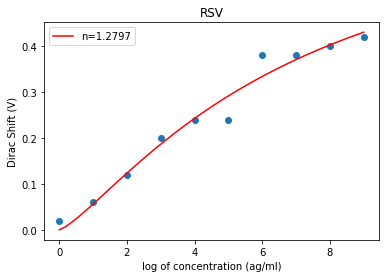

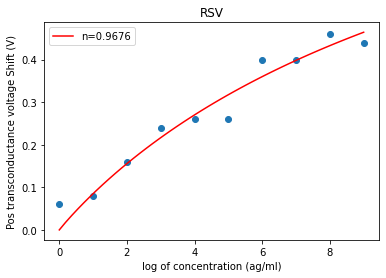

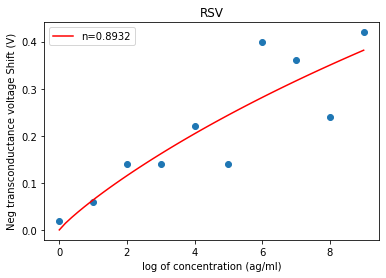

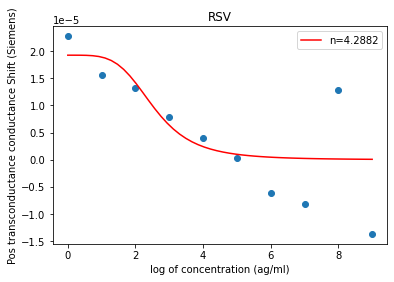

C:\Users\joeyl\Downloads\GFET-covid-flu\utils.py:67: RuntimeWarning: invalid value encountered in scalar power
  return A * (1 - (x**n) / (K**n + x**n))


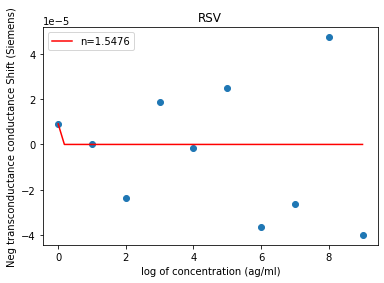

In [6]:
# for RSV, well 3

# filenames to inlude for each concentration
filenames = ['BCdata_B48C13_rsv_1ag_lastsweep.txt', 
             'BCdata_B48C13_rsv_10ag_lastsweep.txt', 
             'BCdata_B48C13_rsv_100ag_lastsweep.txt', 
             'BCdata_B48C13_rsv_1fg_lastsweep.txt', 
             'BCdata_B48C13_rsv_10fg_lastsweep.txt', 
             'BCdata_B48C13_rsv_100fg_lastsweep.txt', 
             'BCdata_B48C13_rsv_1pg_lastsweep.txt', 
             'BCdata_B48C13_rsv_10pg_lastsweep.txt', 
             'BCdata_B48C13_rsv_100pg_lastsweep.txt', 
             'BCdata_B48C13_rsv_1ng_lastsweep.txt']

# makes dataset for each respective filename
datasets = [DataSweep(filename) for filename in filenames]

# makes list of diracs, transconductances, and conductances for all devices
dirac_voltages = [dataset.dirac_voltages() for dataset in datasets]
transconductance_voltages = [dataset.transconductance_voltages() for dataset in datasets]
transconductance_conductances = [dataset.transconductance_conductances() for dataset in datasets]

# makes lists for a specific device, and for specific pos and neg transc. datasets
dev_num = '1'
dev_dirac_voltages = [dev[dev_num] for dev in dirac_voltages]
dev_transconductance_voltages_pos = [dev[dev_num + '+'] for dev in transconductance_voltages]
dev_transconductance_voltages_neg = [dev[dev_num + '-'] for dev in transconductance_voltages]
dev_transconductance_conductances_pos = [dev[dev_num + '+'] for dev in transconductance_conductances]
dev_transconductance_conductances_neg = [dev[dev_num + '-'] for dev in transconductance_conductances]

concentrations = range(0, 10)

# calculates baselines for each calculation, from the aptemer dataset
dataset_apt = DataSweep('BCdata_B48C13_rsv_aptamers_lastsweep.txt')
dirac_baseline = dataset_apt.dirac_voltages()[dev_num]
transconductance_baseline_pos = dataset_apt.transconductance_voltages()[dev_num+'+']
transconductance_baseline_neg = dataset_apt.transconductance_voltages()[dev_num+'-']
transconductance_conductances_baseline_pos = dataset_apt.transconductance_conductances()[dev_num+'+']
transconductance_conductances_baseline_neg = dataset_apt.transconductance_conductances()[dev_num+'-']

# adjusts values based on the baselines
adj_dev_dirac_voltages = [val - dirac_baseline for val in dev_dirac_voltages]
adj_dev_transconductance_voltages_pos = [val - transconductance_baseline_pos for val in dev_transconductance_voltages_pos]
adj_dev_transconductance_voltages_neg = [val - transconductance_baseline_neg for val in dev_transconductance_voltages_neg]
adj_dev_transconductance_conductances_pos = [val - transconductance_conductances_baseline_pos for val in dev_transconductance_conductances_pos]
adj_dev_transconductance_conductances_neg = [val - transconductance_conductances_baseline_neg for val in dev_transconductance_conductances_neg]

# dirac voltage shifts
plt.scatter(concentrations, adj_dev_dirac_voltages, marker='o')
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Dirac Shift (V)")
coeffs, pcov = curve_fit(hill_function, concentrations, adj_dev_dirac_voltages, p0=[1,1,1])
X_fit = np.linspace(min(concentrations), max(concentrations), 50)
hill_function(X_fit, *coeffs)
Y_fit = hill_function(X_fit, *coeffs)
plt.plot(X_fit, Y_fit, color='red', label=f'n={coeffs[2]:.4f}')
plt.legend()
plt.show()
plt.close()

# pos transconductance voltage shifts
plt.scatter(concentrations, adj_dev_transconductance_voltages_pos, marker='o')
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Pos transconductance voltage Shift (V)")
coeffs, pcov = curve_fit(hill_function, concentrations, adj_dev_transconductance_voltages_pos, p0=[1,1,1])
X_fit = np.linspace(min(concentrations), max(concentrations), 50)
hill_function(X_fit, *coeffs)
Y_fit = hill_function(X_fit, *coeffs)
plt.plot(X_fit, Y_fit, color='red', label=f'n={coeffs[2]:.4f}')
plt.legend()
plt.show()
plt.close()

# neg transconductance voltage shifts
plt.scatter(concentrations, adj_dev_transconductance_voltages_neg, marker='o')
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Neg transconductance voltage Shift (V)")
coeffs, pcov = curve_fit(hill_function, concentrations, adj_dev_transconductance_voltages_neg, p0=[1,1,1])
X_fit = np.linspace(min(concentrations), max(concentrations), 50)
hill_function(X_fit, *coeffs)
Y_fit = hill_function(X_fit, *coeffs)
plt.plot(X_fit, Y_fit, color='red', label=f'n={coeffs[2]:.4f}')
plt.legend()
plt.show()
plt.close()

# pos transconductance conductance shifts
plt.scatter(concentrations, adj_dev_transconductance_conductances_pos, marker='o')
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Pos transconductance conductance Shift (Siemens)")
coeffs, pcov = curve_fit(downward_hill_function, concentrations, adj_dev_transconductance_conductances_pos, p0=[1,1,1])
X_fit = np.linspace(min(concentrations), max(concentrations), 50)
hill_function(X_fit, *coeffs)
Y_fit = downward_hill_function(X_fit, *coeffs)
plt.plot(X_fit, Y_fit, color='red', label=f'n={coeffs[2]:.4f}')
plt.legend()
plt.show()
plt.close()

# neg transconductance conductance shifts
plt.scatter(concentrations, adj_dev_transconductance_conductances_neg, marker='o')
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Neg transconductance conductance Shift (Siemens)")
coeffs, pcov = curve_fit(downward_hill_function, concentrations, adj_dev_transconductance_conductances_neg, p0=[1,1,1])
X_fit = np.linspace(min(concentrations), max(concentrations), 50)
hill_function(X_fit, *coeffs)
Y_fit = downward_hill_function(X_fit, *coeffs)
plt.plot(X_fit, Y_fit, color='red', label=f'n={coeffs[2]:.4f}')
plt.legend()
plt.show()
plt.close()

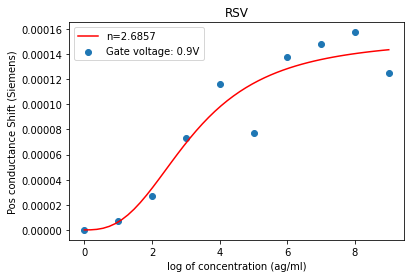

In [7]:
# tracks the conductance values over different concentrations, for a single voltage

conductances_track = []
voltage_to_track = 0.9
conductances_track = [1/dataset.data[dev_num][np.where(dataset.data['voltages'] == voltage_to_track)[0]][0] for dataset in datasets]

# calculates baselines from the aptemer dataset, for conductance. Then adjusts baseline accordingly
dataset_apt = DataSweep('BCdata_B48C13_rsv_aptamers_lastsweep.txt')
conductance_baseline = 1/dataset_apt.data[dev_num][np.where(dataset_apt.data['voltages'] == voltage_to_track)[0]][0]
adj_conductances_track = [val - conductance_baseline for val in conductances_track]

# plotting
plt.scatter(concentrations, adj_conductances_track, marker='o', label=f'Gate voltage: {voltage_to_track}V')
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Conductance Shift (Siemens)")

coeffs, pcov = curve_fit(hill_function, concentrations, adj_conductances_track, p0=[1,1,1])
X_fit = np.linspace(min(concentrations), max(concentrations), 50)
hill_function(X_fit, *coeffs)
Y_fit = hill_function(X_fit, *coeffs)
plt.plot(X_fit, Y_fit, color='red', label=f'n={coeffs[2]:.4f}')

# coefficients = np.polyfit(concentrations, adj_conductances_track, 4)  # 4 is the degree of the polynomial
# polynomial = np.poly1d(coefficients)
# X_fit = np.linspace(min(concentrations), max(concentrations), 100)
# Y_fit = polynomial(X_fit)
# plt.plot(X_fit, Y_fit, color='red')

plt.legend()
plt.show()
plt.close()
